In [ ]:
# Basic imports
import os
import sys
import pickle
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')
sys.path.insert(0, './src')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression
from missforest import MissForest

# Statistic imports
from scipy.special import kl_div
from scipy.stats import ks_2samp, entropy, wasserstein_distance

# Custom modules
from src.gain import *
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cmap import Colormap

# Ignore warnings
warnings.filterwarnings("ignore")

# Load data

In [ ]:
data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
dict_select = data["dict_select"]

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

div_cmap = Colormap('cmasher:fusion')
seq_cmap = Colormap('bids:magma')

# List Imputers

In [ ]:
random_state=42
n_imputation_iter = 100

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
    ("KNNImputer_5", KNNImputer(n_neighbors=5)),
    ("IterativeImputer", IterativeImputer(max_iter=n_imputation_iter, random_state=random_state)),
    ("MissForest", MissForest(max_iter=n_imputation_iter)),
    ("GAINImputer", GAINImputer(**gain_parameters))
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_5, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imp

# Compute imputed data distributions

In order to have a look at the features imputed by our different algorithms, we will just impute some of the data with the different algorithms on the training set with all the missing values to see if the distributions of imputed data do not diverge too much from the original ones. 

In [5]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

In [6]:
df_X_imputed_list = {"Original" : df_X_train}

ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

imputed_filename = "dict_imputed_df_X"

file_path = os.path.join(results_pickle_folder, f"{imputed_filename}.pickle")

if os.path.exists(file_path):
    print(f"The file '{imputed_filename}' already exists'.")
    with open(file_path, "rb") as file: 
        df_X_imputed_list = pd.read_pickle(file)
else:

    for imputer_name, continuous_imputer in continuous_imputer_list: 
        df_X_imputed = df_X_train.copy()

        continuous_imputer.fit(df_X_train[continuous_features])
        
        df_X_imputed[continuous_features] = continuous_imputer.transform(df_X_train[continuous_features])
        df_X_imputed_list[imputer_name] = df_X_imputed

    file_path = os.path.join(results_pickle_folder, f"{imputed_filename}.pickle")

    with open(file_path, 'wb') as file:
        pickle.dump(df_X_imputed_list, file)
    print(f"The dictionary has been saved as '{imputed_filename}.pkl' in the folder ''.")

100%|██████████| 1000/1000 [05:43<00:00,  2.91it/s]


The dictionary has been saved as 'dict_imputed_df_X.pkl' in the folder ''.


In [7]:
cols_to_check = ['ABETA', 'TAU', 'PTAU', 'CREB5', 'CLIC1', 'CD63']

imputed_X_lst = list(df_X_imputed_list.values())
imputed_name_lst = list(df_X_imputed_list.keys())

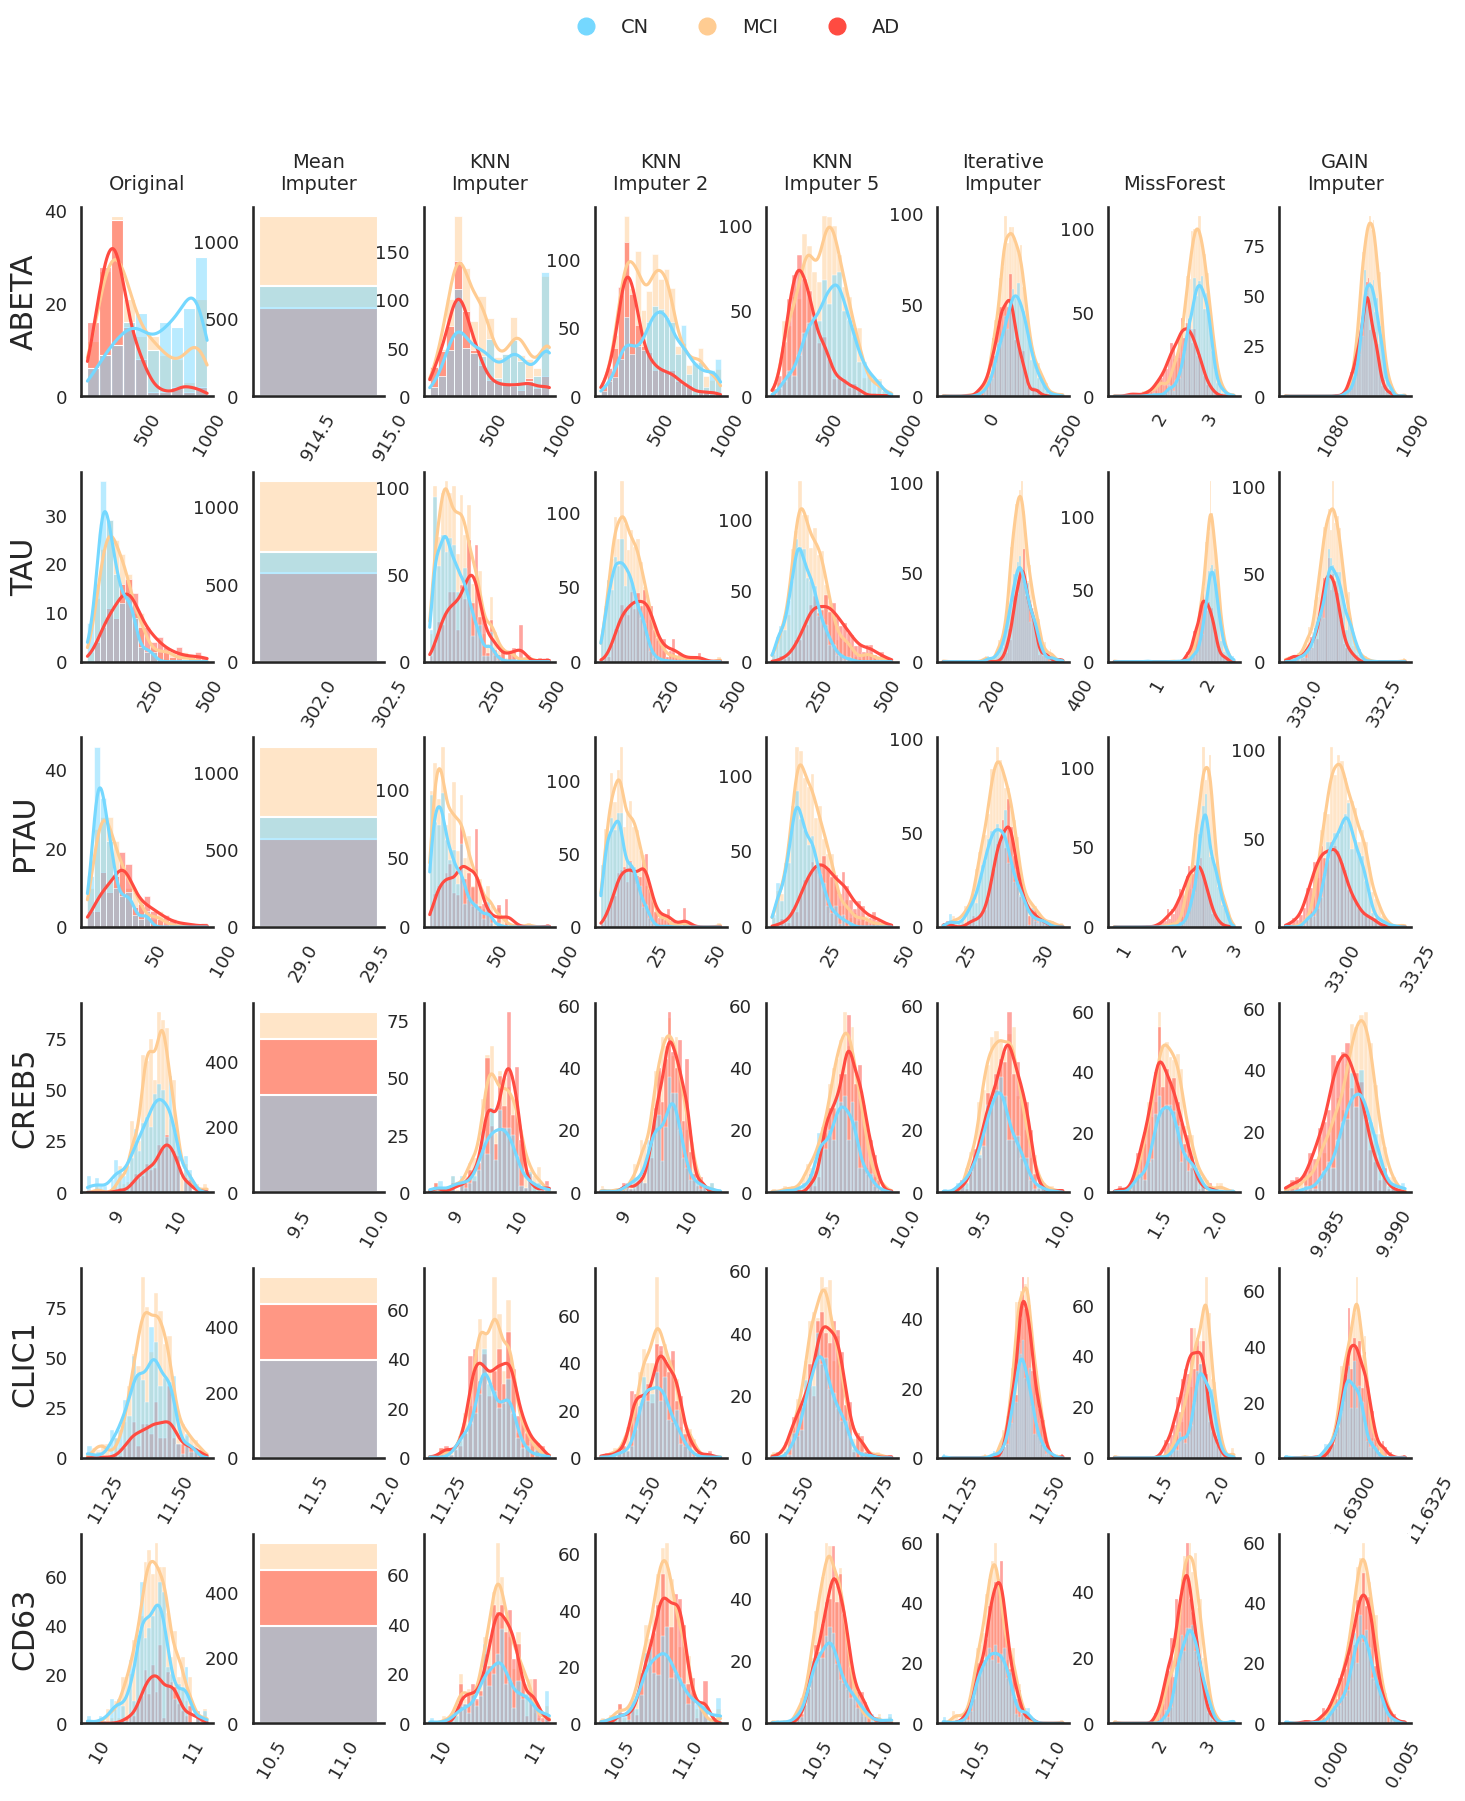

In [8]:
hue_col = df_all.DX[idx_train]
palette = dx_palette

sns.set_style("white")
sns.set_context("talk")

df_X0 = imputed_X_lst[0]

fig, axes = plt.subplots(nrows=len(cols_to_check), ncols=len(imputed_X_lst), figsize=(15, 18))
axes = np.array(axes)

original_ticks = {}

for i, plot_X in enumerate(imputed_X_lst):
    for j, col in enumerate(cols_to_check):
        if imputed_name_lst[i] != "Original":
            plot_X_filtered = plot_X[df_X0[col].isna()]
        else:
            plot_X_filtered = plot_X
            original_ticks[col] = [
                np.floor(plot_X[col].min()),
                np.floor((plot_X[col].min() + plot_X[col].max()) / 2),
                np.ceil(plot_X[col].max()),
            ]

        sns.histplot(
            plot_X_filtered,
            x=col,
            hue=hue_col,
            ax=axes[j][i],
            palette=palette,
            kde=(imputed_name_lst[i] != "SimpleImputer_mean"),
            legend=False,
        )

        axes[j][i].set_xlabel("")
        axes[j][i].set_ylabel("")
        axes[j][i].set_xticklabels(axes[j][i].get_xticklabels(), rotation=60, ha="left", fontsize=13)
        axes[j][i].set_yticklabels(axes[j][i].get_yticklabels(), ha="right", fontsize=13)
        axes[j][i].xaxis.set_major_locator(MaxNLocator(nbins=2, integer=True))
        axes[j][i].tick_params(pad=1)
        sns.despine()

# Set column titles with proper spacing
for ax, col in zip(axes[0], imputed_name_lst):
    ax.set_title(
        col.replace("SimpleImputer_mean", "MeanImputer")
           .replace("_", " ")
           .replace("Imputer", "\nImputer")
           .replace("(", "\n("),
        pad=12,  # Add padding above titles
        fontsize=14
    )

# Set row labels
for ax, col in zip(axes[:, 0], cols_to_check):
    ax.set_ylabel(col.replace("_", " "), rotation=90, size="large")

# Legend (centered above)
if palette is not None:
    handles = [
        mlines.Line2D([], [], color=color, marker="o", linestyle="", markersize=12, label=label)
        for label, color in palette.items()
    ]
    fig.legend(
        handles=handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.01),  # Bring legend closer
        ncol=len(palette),
        frameon=False,
        fontsize=14
    )

# Reduce space between plots and legend
plt.tight_layout(rect=[0, 0, 1, 0.94])  # Reserve top space for legend
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Save
plt.savefig("../figures/imputation_distribution_plots.png", format="png", bbox_inches="tight")
plt.show()


In [9]:
df_X_imputed_list
features_of_interest=cols_to_check
savefolder = "../figures/imputation"
heatmap_annot=True

original_df = df_X_imputed_list['Original']
ks_stats = {}
p_values = {}
kl_divergences = {}

In [180]:
def compute_imputation_stats(original_df, df_X_imputed_list, features_of_interest):
    ks_stats = {}
    p_values = {}
    kl_divergences = {}
    entropies = {}
    wasserstein_distances = {}
    ecdf_data_dict = {}

    for feature_name in features_of_interest:
        ks_stats[feature_name] = {}
        p_values[feature_name] = {}
        kl_divergences[feature_name] = {}
        entropies[feature_name] = {}
        wasserstein_distances[feature_name] = {}

        # Clean original (non-missing values)
        original_clean = original_df[feature_name].dropna()
        missing_indices = original_df[feature_name].isna()

        # Common histogram bins based on original
        bins = np.histogram_bin_edges(original_clean, bins="fd")

        # Histogram for original
        original_hist, _ = np.histogram(original_clean, bins=bins, density=True)
        original_hist += 1e-9  # smoothing
        original_hist /= original_hist.sum()  # normalize


        # ECDF container
        ecdf_data = pd.DataFrame()

        for method, imputed_df in df_X_imputed_list.items():
            if method == 'Original':
                continue

            imputed_values = imputed_df.loc[missing_indices, feature_name].dropna()

            # KS test
            ks_stat, p_value = ks_2samp(original_clean, imputed_values)
            ks_stats[feature_name][method] = ks_stat
            p_values[feature_name][method] = p_value

            # Histogram for imputed values
            imputed_hist, _ = np.histogram(imputed_values, bins=bins, density=True)
            imputed_hist += 1e-9
            imputed_hist /= imputed_hist.sum()

            # KL divergence
            kl_divergences[feature_name][method] = entropy(original_hist, imputed_hist, base=2, nan_policy='omit')

            # Wasserstein distance (directly on raw values)
            print(f"Calculating Wasserstein distance for {feature_name} using method {method}")
            print(original_clean.shape, imputed_values.shape)

            w_distance = wasserstein_distance(original_clean, imputed_values)
            wasserstein_distances[feature_name][method] = w_distance

            # ECDF
            temp_df = pd.DataFrame({
                'Value': np.sort(imputed_values),
                'ECDF': np.arange(len(imputed_values)) / len(imputed_values),
                'Method': method
            })
            ecdf_data = pd.concat([ecdf_data, temp_df], ignore_index=True)

        # ECDF for original
        original_ecdf = pd.DataFrame({
            'Value': np.sort(original_clean),
            'ECDF': np.arange(len(original_clean)) / len(original_clean),
            'Method': 'Original'
        })
        ecdf_data = pd.concat([ecdf_data, original_ecdf], ignore_index=True)

        ecdf_data_dict[feature_name] = ecdf_data

    return (
        ecdf_data_dict,
        ks_stats,
        p_values,
        kl_divergences,
        wasserstein_distances
    )

In [244]:
select_imputed_features = dict_select["RNA"]+dict_select["CSF"]
# Compute all ECDFs and stats
ecdf_data_dict, ks_stats, p_values, kl_divs,  wasserstein = compute_imputation_stats(original_df, df_X_imputed_list, select_imputed_features)

Calculating Wasserstein distance for CREB5 using method SimpleImputer_mean
(1563,) (1318,)
Calculating Wasserstein distance for CREB5 using method KNNImputer
(1563,) (1318,)
Calculating Wasserstein distance for CREB5 using method KNNImputer_2
(1563,) (1318,)
Calculating Wasserstein distance for CREB5 using method KNNImputer_5
(1563,) (1318,)
Calculating Wasserstein distance for CREB5 using method IterativeImputer
(1563,) (1318,)
Calculating Wasserstein distance for CREB5 using method MissForest
(1563,) (1318,)
Calculating Wasserstein distance for CREB5 using method GAINImputer
(1563,) (1318,)
Calculating Wasserstein distance for CLIC1 using method SimpleImputer_mean
(1563,) (1318,)
Calculating Wasserstein distance for CLIC1 using method KNNImputer
(1563,) (1318,)
Calculating Wasserstein distance for CLIC1 using method KNNImputer_2
(1563,) (1318,)
Calculating Wasserstein distance for CLIC1 using method KNNImputer_5
(1563,) (1318,)
Calculating Wasserstein distance for CLIC1 using method 

In [206]:
def plot_ecdf_grid(ecdf_data_dict, features_of_interest, savefolder=None):

    sns.set_style("white")
    sns.set_context("talk")

    selected_features = [f for f in features_of_interest if f in ecdf_data_dict]
    num_features = len(selected_features)
    ncols = 3
    nrows = (num_features + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 4))
    axes = axes.flatten()

    for i, feature_name in enumerate(selected_features):
        ecdf_data = ecdf_data_dict[feature_name]

        sns.lineplot(
            data=ecdf_data,
            x="Value",
            y="ECDF",
            hue="Method",
            ax=axes[i],
            palette=sns.color_palette("Set1"),
            linewidth=3,
            alpha=0.8
        )

        axes[i].set_title(feature_name)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('ECDF')
        axes[i].get_legend().remove()
        sns.despine()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Global legend
    handles, labels = axes[0].get_legend_handles_labels()
    labels = [l.replace("SimpleImputer_mean", "MeanImputer")
                .replace("Imputer", " Imputer")
                .replace("_", " ")
                .replace("(", " (") for l in labels]

    fig.legend(
        handles, labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.02),
        ncol=min(len(labels), 4),
        title="Imputation Method",
        frameon=False,
        fontsize=16,
        title_fontsize=18
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.9])

    if savefolder is not None:
        plt.savefig(f"{savefolder}_ecdf_plot.png", format="png", bbox_inches='tight')

    plt.show()


In [207]:
def plot_metric_heatmap(
    metric_df,
    metric_name,
    df_select_features=None,  # NEW: for grouping features by source
    features_of_interest=None,
    annotations_df=None,
    savefolder=None,
    cmap="vlag",
    vmin=None,
    vmax=None,
    cbar_ticks=None,
    figsize=(14, 6),
    dpi=300,
    font_scale=1.2,
    annot_format_func=None
):
    """
    Plots a high-quality heatmap for a given metric, with features grouped and sorted by domain and metric mean.
    """

    # Extract feature grouping if provided
    if df_select_features is not None:
        grouped_sorted_features = []

        # Convert to dict: {source: [features]}
        grouped_features = df_select_features.to_dict(orient='list')
        grouped_features = {k: [f for f in v if f in metric_df.index] for k, v in grouped_features.items()}

        # Sort within each group by average metric value across methods
        for source, features in grouped_features.items():
            feature_means = metric_df.loc[features].mean(axis=1)
            sorted_features = feature_means.sort_values(ascending=False).index.tolist()
            grouped_sorted_features.extend(sorted_features)

        metric_df = metric_df.loc[grouped_sorted_features]
        if annotations_df is not None:
            annotations_df = annotations_df.loc[grouped_sorted_features]

    # Optionally subset features
    elif features_of_interest is not None:
        metric_df = metric_df.loc[features_of_interest]
        if annotations_df is not None:
            annotations_df = annotations_df.loc[features_of_interest]

    # Sort imputation methods (rows) by mean metric value (descending)
    method_means = metric_df.mean(axis=1).sort_values(ascending=False)
    metric_df = metric_df.loc[method_means.index]
    if annotations_df is not None:
        annotations_df = annotations_df.loc[method_means.index]

    # Format annotations
    if annotations_df is not None and annot_format_func is not None:
        annotations_df = annotations_df.applymap(annot_format_func)

    # Set styles
    sns.set_context("talk", font_scale=font_scale)
    sns.set_style("white")

    # Plot
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    sns.heatmap(
        metric_df,
        annot=annotations_df if annotations_df is not None else None,
        fmt="" if annotations_df is None else ".2f",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        linecolor="lightgrey",
        square=False,
        cbar_kws={'label': metric_name, 'ticks': cbar_ticks} if cbar_ticks else {'label': metric_name},
        ax=ax
    )

    # Clean y-tick labels (methods)
    ax.set_yticklabels([
        label.get_text()
        .replace("SimpleImputer_mean", "Mean Imputer")
        .replace("IterativeImputer", "Iterative Imputer")
        .replace("KNNImputer", "KNN Imputer")
        .replace("MissForest", "MissForest")
        .replace("Imputer", " Imputer")
        .replace("_", " ")
        for label in ax.get_yticklabels()
    ], rotation=0, fontsize=12)

    # Clean x-tick labels (features)
    ax.set_xticklabels([
        label.get_text().replace("_", " ") for label in ax.get_xticklabels()
    ], rotation=45, ha='right', fontsize=12)

    ax.set_ylabel("Imputation Method", fontsize=14)
    ax.set_xlabel("Feature", fontsize=14)
    plt.tight_layout()

    # Save
    if savefolder is not None:
        fname = f"{savefolder}_{metric_name.lower().replace(' ', '_')}_heatmap.png"
        plt.savefig(fname, bbox_inches="tight", format="png")

    plt.show()


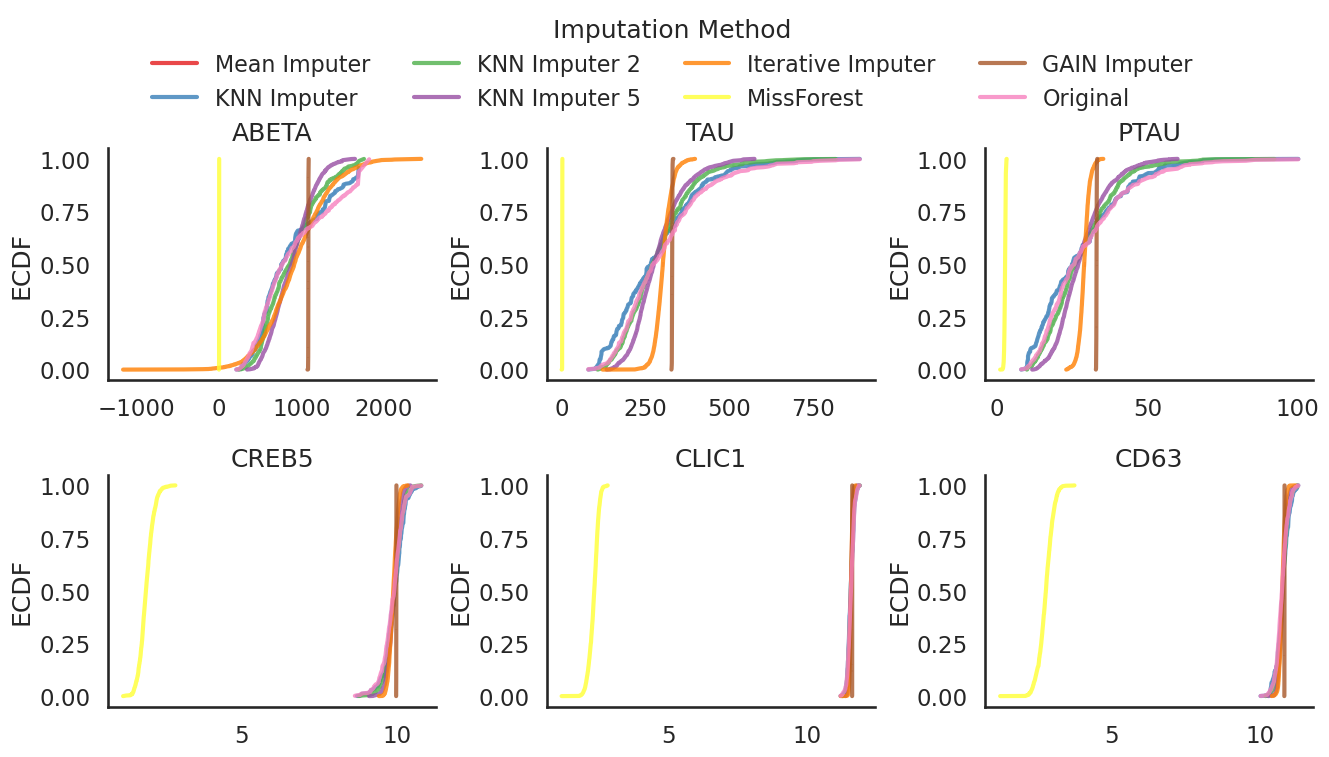

In [208]:
plot_ecdf_grid(ecdf_data_dict, features_of_interest=cols_to_check ,savefolder="../figures/imputation/ecdf")


In [209]:
# Convert results to DataFrames for heatmaps
ks_stats_df = pd.DataFrame(ks_stats).T.dropna()
p_values_df = pd.DataFrame(p_values).T.dropna()
kl_divergences_df = pd.DataFrame(kl_divs).T.dropna()
wasserstein_df = pd.DataFrame(wasserstein).T.dropna()

In [214]:
def plot_metric_heatmap(
    metric_df,
    metric_name,
    features_of_interest=None,
    annotations_df=None,
    savefolder=None,
    cmap="vlag",
    vmin=None,
    vmax=None,
    cbar_ticks=None,
    figsize=(14, 6),
    dpi=300,
    font_scale=1.2,
    annot_format_func=None,
    keys_list=None,
    full_palette=None
):
    """
    Plots a sorted, grouped heatmap with optional annotations and color grouping by modality.
    """

    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    sns.set_context("talk", font_scale=font_scale)
    sns.set_style("white")

    # Subset and sort features
    if features_of_interest is not None:
        metric_df = metric_df.loc[features_of_interest]
        if annotations_df is not None:
            annotations_df = annotations_df.loc[features_of_interest]

    # Sort columns (features) by mean metric across imputers
    feature_means = metric_df.mean(axis=0)
    sorted_features = feature_means.sort_values().index.tolist()
    metric_df = metric_df[sorted_features]
    if annotations_df is not None:
        annotations_df = annotations_df[sorted_features]

    # Create modality group colors
    if keys_list is not None and full_palette is not None:
        cat_palette = {}
        new_key_list = []
        for i, mod in enumerate(["MRIth", "RNA", "CSF", "DNA", "ADNI_cog"]):
            is_modal = [k == mod for k in keys_list]
            new_key_list.extend(np.array(keys_list)[is_modal])
            cat_palette[mod] = list(full_palette.values())[i]

        # Make sure row_colors aligns with sorted feature list
        feature_to_modality = dict(zip(keys_list, keys_list))  # keys_list is aligned with metric_df.columns
        col_colors = pd.Series(sorted_features).map(lambda x: cat_palette.get(feature_to_modality.get(x, ""), "grey"))
    else:
        col_colors = None
        cat_palette = {}

    # Format annotations
    if annotations_df is not None and annot_format_func is not None:
        annotations_df = annotations_df.applymap(annot_format_func)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    sns.heatmap(
        metric_df.transpose(),
        annot=annotations_df.transpose() if annotations_df is not None else None,
        fmt="",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        linecolor="lightgrey",
        square=False,
        cbar_kws={'label': metric_name, 'ticks': cbar_ticks} if cbar_ticks else {'label': metric_name},
        ax=ax
    )

    # Clean tick labels
    ax.set_yticklabels(
        [label.get_text().replace("_", " ") for label in ax.get_yticklabels()],
        rotation=0, fontsize=11
    )
    ax.set_xticklabels(
        [label.get_text().replace("_", " ") for label in ax.get_xticklabels()],
        rotation=45, ha='right', fontsize=11
    )

    ax.set_ylabel("Imputation Method", fontsize=13)
    ax.set_xlabel("Feature", fontsize=13)

    # Add legend for group colors (feature modality)
    if col_colors is not None:
        modality_legend = [Patch(facecolor=color, label=label) for label, color in cat_palette.items()]
        ax.legend(handles=modality_legend, title="Feature Type", bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()

    # Save if requested
    if savefolder is not None:
        fname = f"{savefolder}_{metric_name.lower().replace(' ', '_')}_heatmap.png"
        plt.savefig(fname, bbox_inches="tight", format="png")

    plt.show()


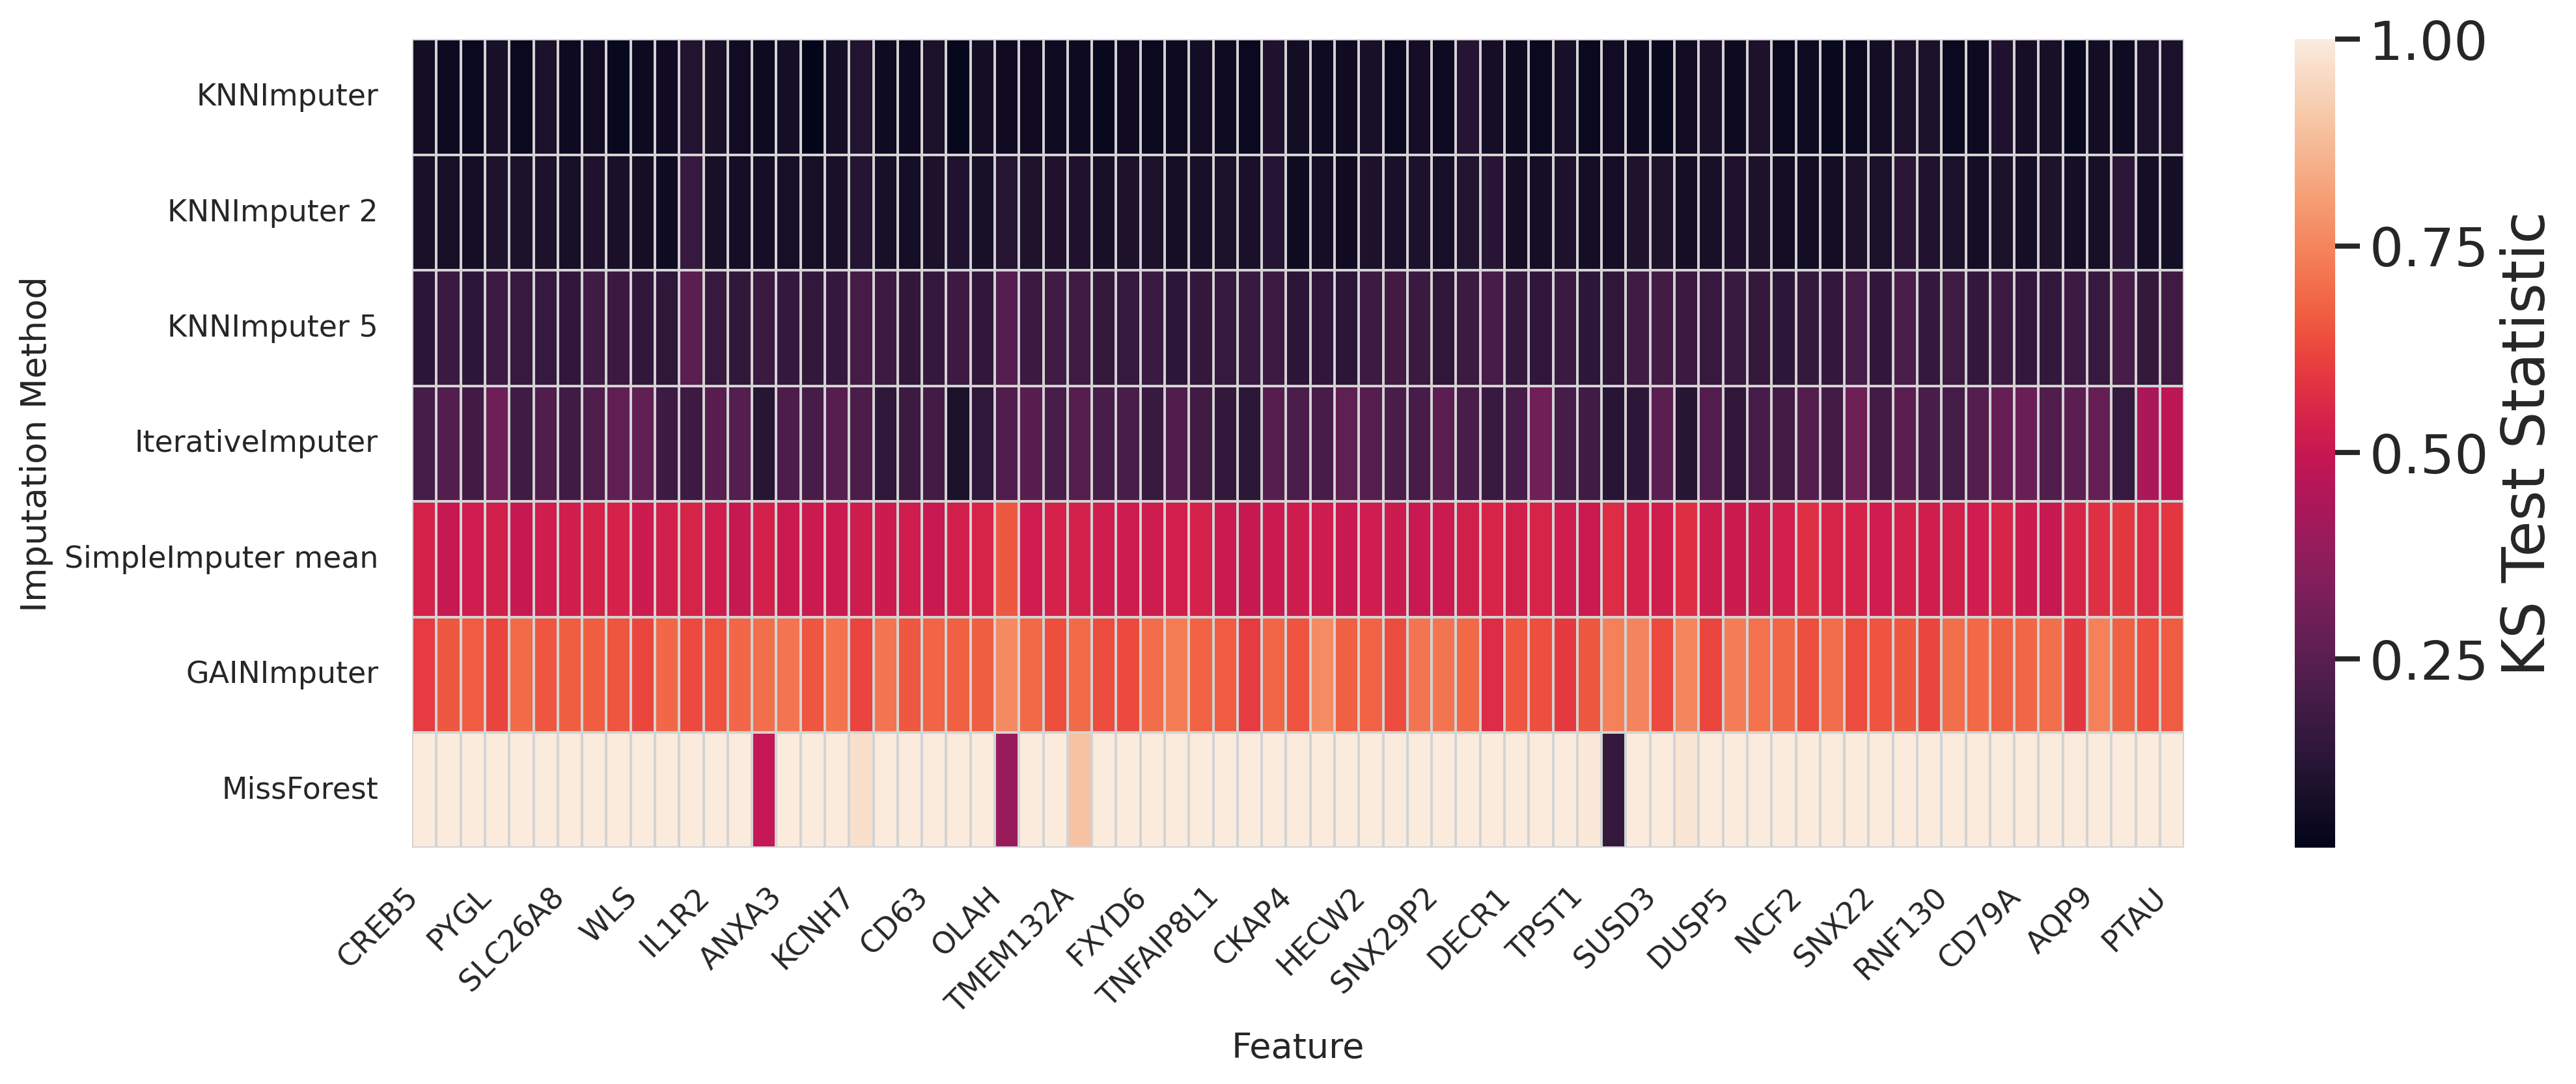

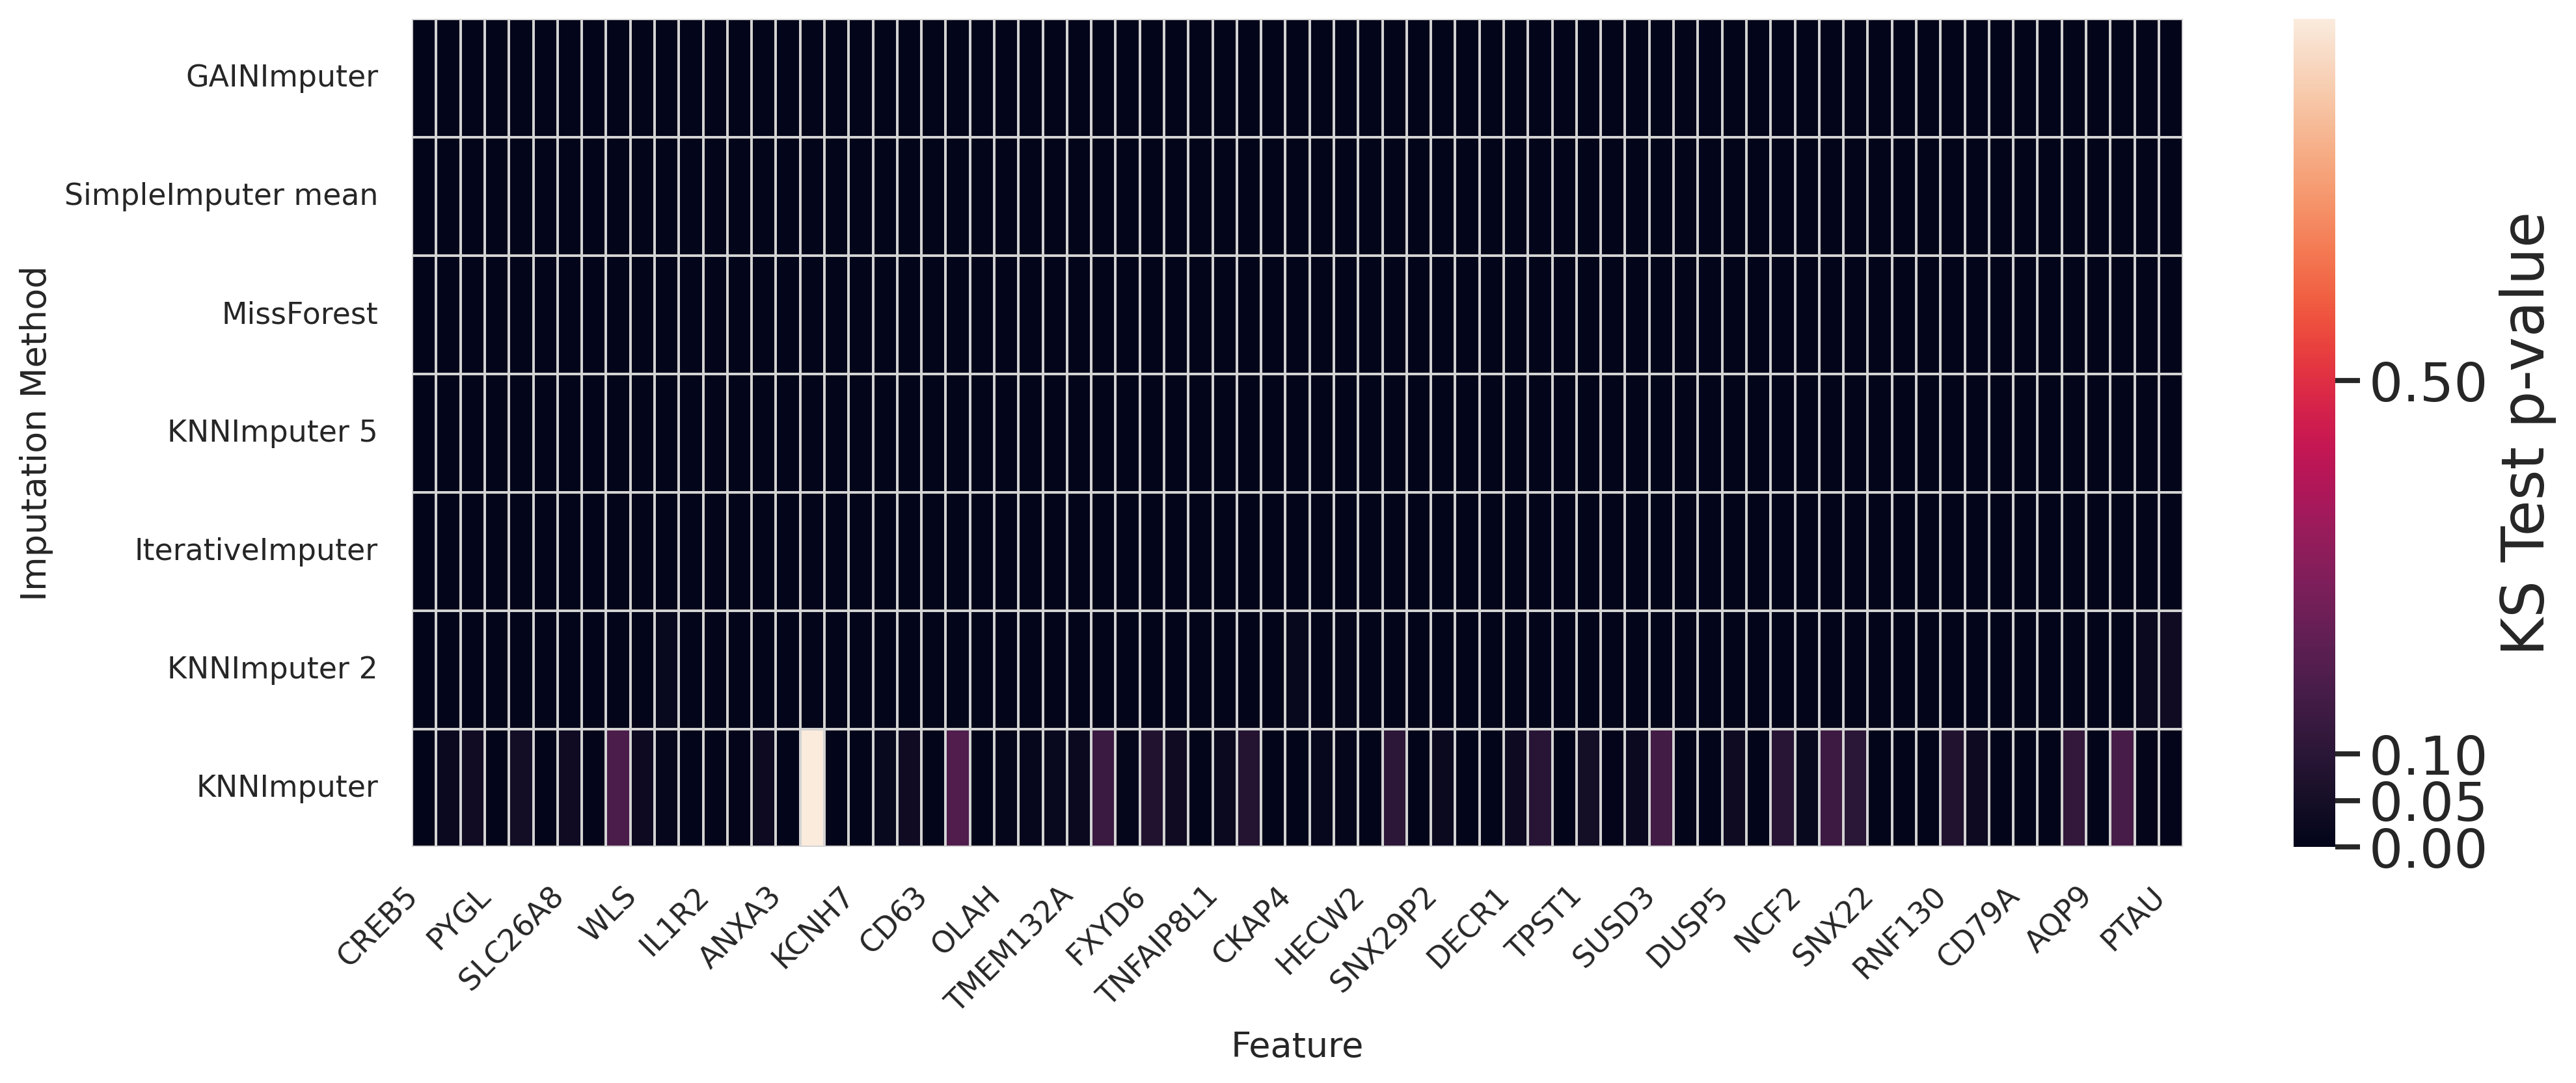

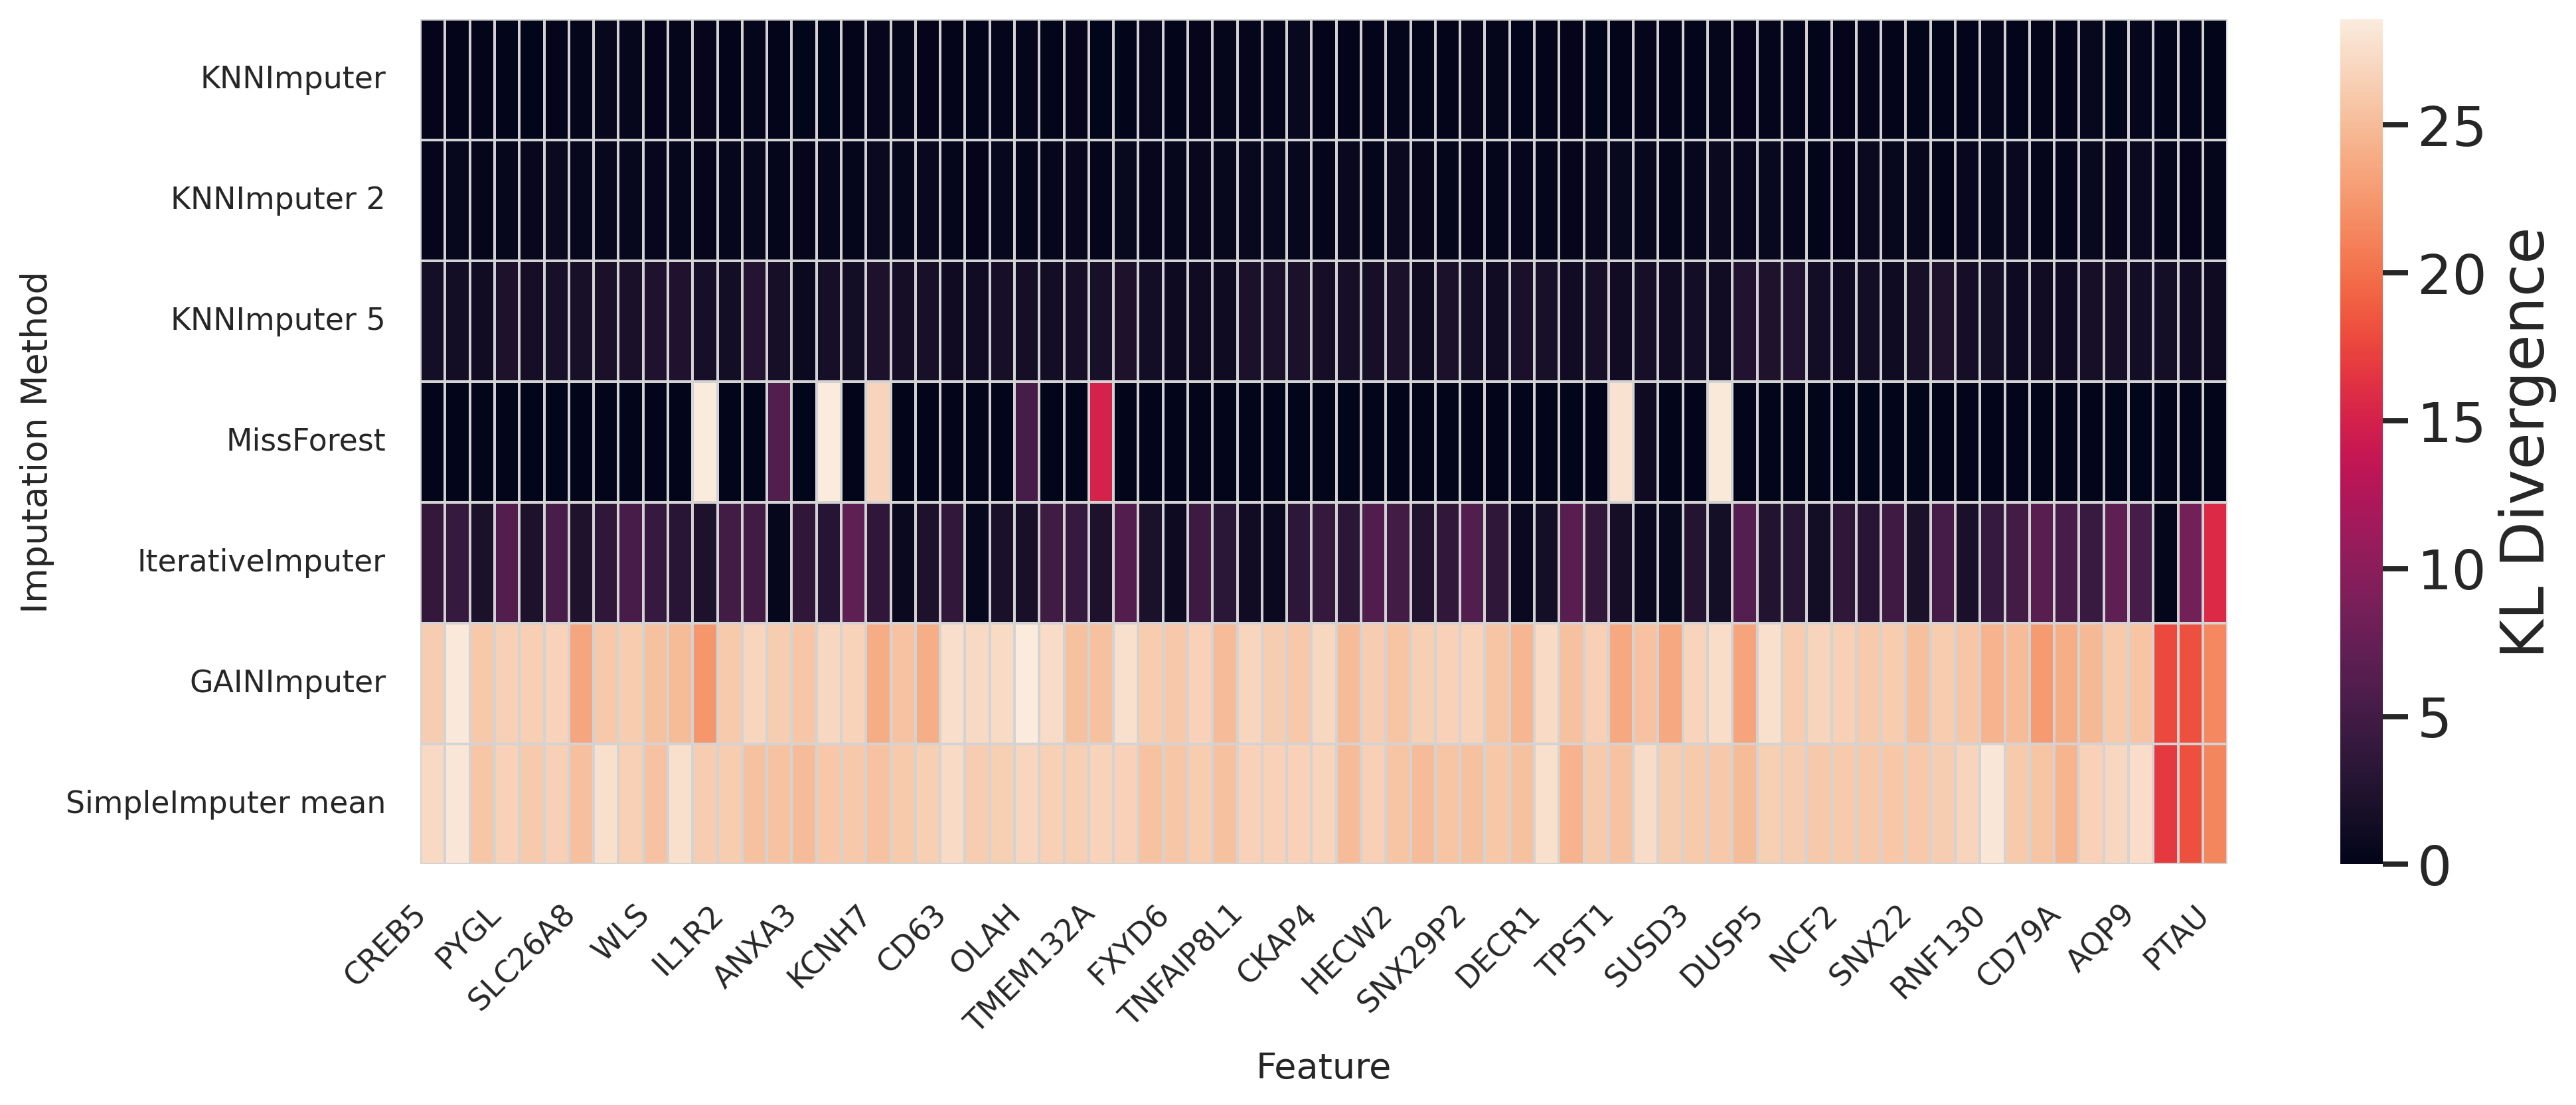

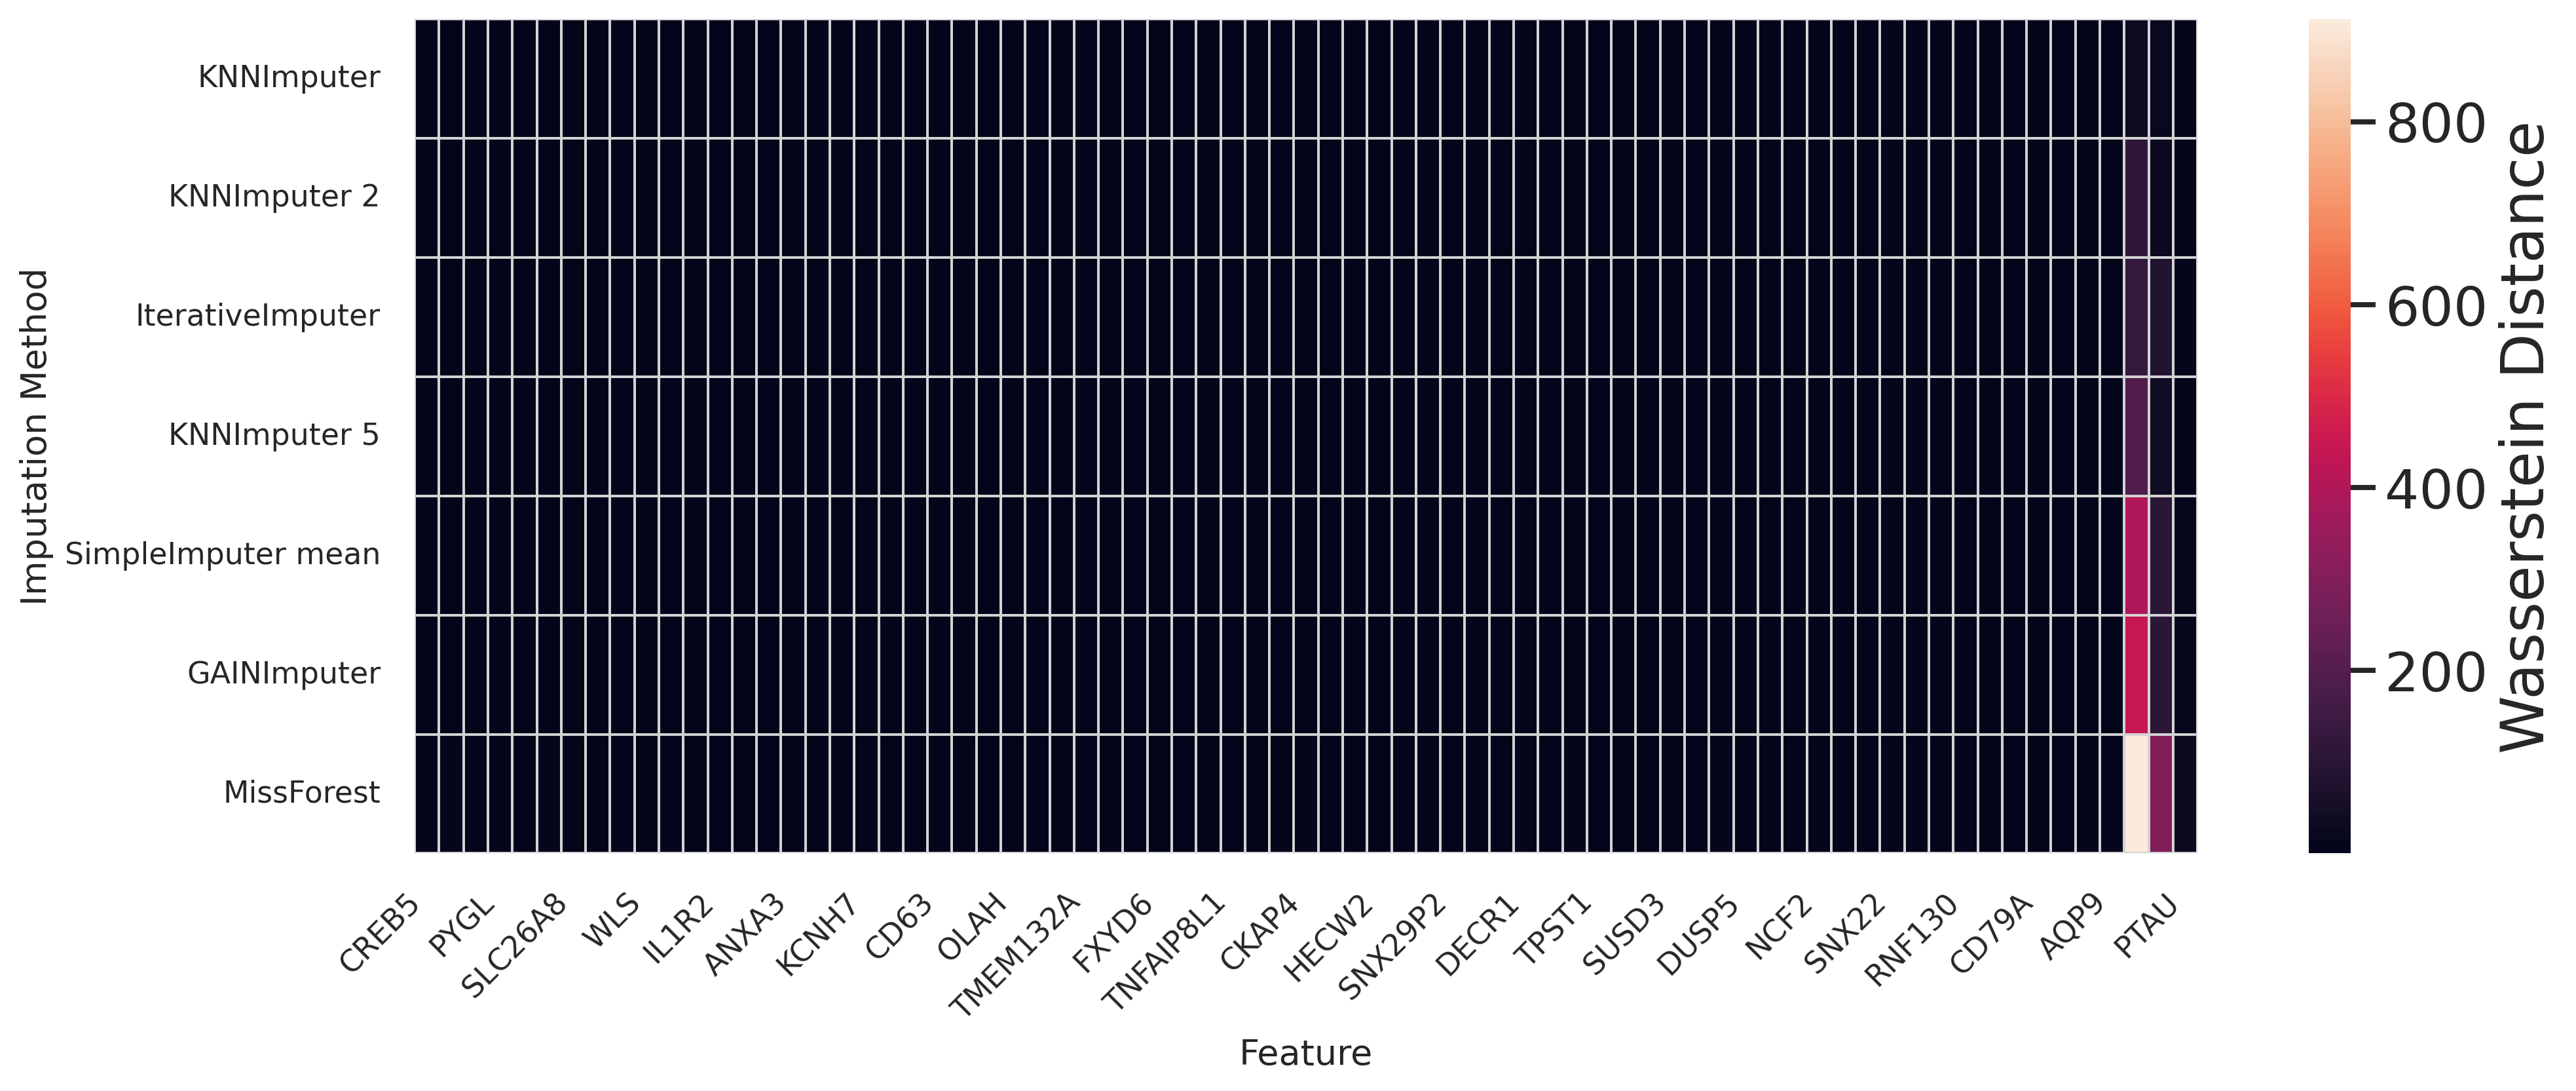

In [225]:
# KS Statistic
plot_metric_heatmap(
    metric_df=ks_stats_df,
    metric_name="KS Test Statistic",
    features_of_interest=ks_stats_df.index,
    annotations_df=None,
    savefolder=savefolder,
    cmap="rocket",
    cbar_ticks=[0.0, 0.25, 0.5, 0.75, 1.0]
)

# P-values
plot_metric_heatmap(
    metric_df=p_values_df,
    metric_name="KS Test p-value",
    features_of_interest=p_values_df.index,
    annotations_df=None,
    savefolder=savefolder,
    cmap="rocket",
    cbar_ticks=[0.0, 0.05, 0.1, 0.5, 1.0]
)

# KL Divergence
plot_metric_heatmap(
    metric_df=kl_divergences_df,
    metric_name="KL Divergence",
    features_of_interest=kl_divergences_df.index,
    annotations_df=None,
    savefolder=savefolder,
    cmap="rocket",
)

# KL Divergence
plot_metric_heatmap(
    metric_df=wasserstein_df,
    metric_name="Wasserstein Distance",
    features_of_interest=wasserstein_df.index,
    annotations_df=None,
    savefolder=savefolder,
    cmap="rocket",
)

### Order columns by KL divergence and KS test

In [267]:
def average_metrics_by_group(metric_df, feature_groups):
    """
    metric_df: pd.DataFrame, index=features, columns=imputation methods, values=metric scores
    feature_groups: dict, keys=modalities, values=list of feature names
    
    Returns:
        pd.DataFrame with modalities as rows, imputation methods as columns,
        containing average metric values per modality.
    """
    avg_dict = {}

    for group, features in feature_groups.items():
        # Only keep features actually in metric_df index
        valid_features = [f for f in features if f in metric_df.index]
        if not valid_features:
            # skip if no features in metric_df for this group
            continue

        # Compute mean of metrics for those features
        avg_metrics = metric_df.loc[valid_features].mean(axis=0)
        avg_dict[group] = avg_metrics

    # Construct DataFrame from dict of Series
    avg_df = pd.DataFrame.from_dict(avg_dict, orient='index')
    
    return avg_df

In [ ]:
def average_multiple_metrics_by_group(metric_dfs, feature_groups, metric_names=None):
    """
    Averages multiple metric DataFrames across grouped features and returns a combined DataFrame
    with MultiIndex (metric name, modality) on rows.

    Parameters:
        metric_dfs (list of pd.DataFrame): Metric DataFrames with index=features and columns=methods.
        feature_groups (dict): Grouping of features per modality.
        metric_names (list of str, optional): Names corresponding to the metric_dfs. If None, will use indices.

    Returns:
        pd.DataFrame: Rows are (metric_name, modality), columns are imputation methods.
    """
    if metric_names is None:
        metric_names = [f"Metric_{i}" for i in range(len(metric_dfs))]

    combined_rows = []
    combined_index = []

    for metric_df, name in zip(metric_dfs, metric_names):
        avg_df = average_metrics_by_group(metric_df, feature_groups)
        combined_rows.append(avg_df)
        combined_index.extend([(name, idx) for idx in avg_df.index])

    # Concatenate and assign MultiIndex
    result_df = pd.concat(combined_rows)
    result_df.index = pd.MultiIndex.from_tuples(combined_index, names=["Metric", "Modality"])
    
    return result_df


In [273]:
selected_modalities = {x: dict_select[x] for x in ('RNA', 'CSF') if x in dict_select}

summary_df = average_multiple_metrics_by_group(
    metric_dfs=[ks_stats_df, p_values_df, kl_divergences_df, wasserstein_df],
    feature_groups=selected_modalities,
    metric_names=["KS-statistic", "KS-pvalue", "KL divergence", "Wasserstein distance"]
)

summary_df.T

Metric             KS-statistic       KS-pvalue       KL divergence         \
Modality                    RNA   CSF       RNA   CSF           RNA    CSF   
SimpleImputer_mean        0.527 0.582     0.000 0.000        26.193 18.769   
KNNImputer                0.066 0.081     0.044 0.059         0.205  0.077   
KNNImputer_2              0.090 0.096     0.001 0.020         0.435  0.226   
KNNImputer_5              0.167 0.182     0.000 0.000         1.659  1.295   
IterativeImputer          0.212 0.358     0.000 0.000         3.492  8.140   
MissForest                0.970 1.000     0.000 0.000         2.361  0.000   
GAINImputer               0.672 0.659     0.000 0.000        25.912 19.107   

Metric             Wasserstein distance          
Modality                            RNA     CSF  
SimpleImputer_mean                0.374 169.231  
KNNImputer                        0.048  19.371  
KNNImputer_2                      0.086  46.765  
KNNImputer_5                      0.162  79.266  
IterativeImputer                  0.207  73.665  
MissForest                        5.088 412.898  
GAINImputer                       0.411 186.850

# Select preprocessing and transforms using Linear Regression as evaluation  model

In [65]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

Some of the patients with no missing values in the test set are present in the training set so we will remove them from training. 

In [66]:
set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

In [67]:
for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

In [68]:
sum(idx_train) + sum(idx_test) == df_X.shape[0]

True

In [69]:
df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

In [112]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
    ("KNNImputer_5", KNNImputer(n_neighbors=5)),
    ("IterativeImputer", IterativeImputer(max_iter=n_imputation_iter, random_state=random_state)),
    ("MissForest", MissForestWrapper(max_iter=n_imputation_iter)),
    ("GAINImputer", GAINImputer(**gain_parameters))
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_5, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imp

In [70]:
results_file = '../pickle/training_1_dict_results.pickle'

In [290]:
df_y_train.columns

Index(['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN'], dtype='object')

In [119]:
if True: 

    with open(results_file, "rb") as input_file:
        all_dict_results = pickle.load(input_file)

    for continuous_imputer, ordinal_imputer, model in combinations:
        name_continuous_imputer, continuous_imputer_instance = continuous_imputer
        name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
        name_model, model_instance = model

        params = {
            "ordinal_imputer": name_ordinal_imputer, 
            "continuous_imputer": name_continuous_imputer, 
            "model": name_model, "train_shape" : df_X_train.shape, 
            "test_shape": df_X_test.shape
        }

        if any(result['params'] == params for result in all_dict_results):
            # Skip this iteration if the combination exists
            print(f"Skipping existing combination: {params.values()}")
            
            continue

        try: 
        
            # Now you can call your `train_model` function with these components
            dict_results = train_imputer_model(
                df_X_train, df_X_test, df_y_train, df_y_test,
                c_train, c_test,
                ordinal_imputer_instance, name_ordinal_imputer,
                continuous_imputer_instance, name_continuous_imputer,
                model_instance, name_model,
                separate_imputers=True  # Or however you want to specify
            )

        except Exception as e:  

            print(e)
        
            dict_results = {
            "params": params, 
            "imputation_time": None,
            "fitting_time": None, 
            "results_adj": None, 
            "results_org": None
        }
            
        print(dict_results)
            
        # Optionally keep the all_dict_results list updated
        all_dict_results.append(dict_results)

            # Save the updated results back to the pickle file
        with open(results_file, 'wb') as f:
            pickle.dump(all_dict_results, f)


Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'SimpleImputer_mean', 'LinearRegression', (2881, 276), (13, 276)])
Skipping existing combination: dict_values(['KNNImputer', 'SimpleImputer_mean', 'LinearRegression', (2881, 276), (13, 276)])
Skipping existing combination: dict_values(['SimpleImputer_constant', 'SimpleImputer_mean', 'LinearRegression', (2881, 276), (13, 276)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer', 'LinearRegression', (2881, 276), (13, 276)])
Skipping existing combination: dict_values(['KNNImputer', 'KNNImputer', 'LinearRegression', (2881, 276), (13, 276)])
Skipping existing combination: dict_values(['SimpleImputer_constant', 'KNNImputer', 'LinearRegression', (2881, 276), (13, 276)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer_2', 'LinearRegression', (2881, 276), (13, 276)])
Skipping existing combination: dict_values(['KNNImputer', 'KNNImputer_2', 'Linea

100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


No NaN in test data -> Keep as it is. 
{'params': {'ordinal_imputer': 'SimpleImputer_most_frequent', 'continuous_imputer': 'MissForest', 'model': 'LinearRegression', 'train_shape': (2881, 276), 'test_shape': (13, 276)}, 'imputation_time': 1060.0202350616455, 'fitting_time': 1.1303668022155762, 'results_adj': {'mse_score': array([  195.26953707, 64735.90120127, 79186.50047976, 27481.14536119]), 'mae_score': array([ 11.37992987, 234.10145603, 257.75893772, 154.61485618]), 'r2': array([   -196.35461481,  -73457.44817463, -165336.2399842 ,
        -33427.63591584]), 'explained_variance': array([   -78.46762386, -11269.70719466, -26613.71035994,  -4348.18060253]), 'corr': array([ 0.61134701, -0.04260639,  0.41852301,  0.56442834])}, 'results_org': {'mse_score': array([  195.26953699, 64735.90119561, 79186.5004701 , 27481.14536129]), 'mae_score': array([ 11.37992987, 234.10145602, 257.7589377 , 154.61485619]), 'r2': array([   -206.71646823,  -72521.07355985, -154229.1349378 ,
        -32129.

100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


No NaN in test data -> Keep as it is. 
{'params': {'ordinal_imputer': 'KNNImputer', 'continuous_imputer': 'MissForest', 'model': 'LinearRegression', 'train_shape': (2881, 276), 'test_shape': (13, 276)}, 'imputation_time': 1049.3031244277954, 'fitting_time': 0.09802842140197754, 'results_adj': {'mse_score': array([4.64181463e+01, 6.61729626e+04, 8.84624398e+04, 2.86329773e+04]), 'mae_score': array([  4.74238678, 236.83840966, 272.39466699, 157.75897804]), 'r2': array([-4.59137968e+01, -7.50881400e+04, -1.84703913e+05, -3.48287482e+04]), 'explained_variance': array([   -31.17967508, -11437.78594564, -29780.61431027,  -4554.59573952]), 'corr': array([ 0.22391698, -0.03492502,  0.41786556,  0.56455955])}, 'results_org': {'mse_score': array([4.64181463e+01, 6.61729626e+04, 8.84624398e+04, 2.86329773e+04]), 'mae_score': array([  4.74238678, 236.83840964, 272.39466697, 157.75897804]), 'r2': array([-4.83769461e+01, -7.41309789e+04, -1.72295717e+05, -3.34764403e+04]), 'explained_variance': arra

100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


No NaN in test data -> Keep as it is. 
{'params': {'ordinal_imputer': 'SimpleImputer_constant', 'continuous_imputer': 'MissForest', 'model': 'LinearRegression', 'train_shape': (2881, 276), 'test_shape': (13, 276)}, 'imputation_time': 1036.6433708667755, 'fitting_time': 1.9052894115447998, 'results_adj': {'mse_score': array([3.43862958e+01, 6.39900875e+04, 8.43193304e+04, 2.69168302e+04]), 'mae_score': array([  4.10060761, 232.63420516, 265.87942544, 153.08881587]), 'r2': array([-3.37534709e+01, -7.26111432e+04, -1.76053318e+05, -3.27411912e+04]), 'explained_variance': array([-2.56440082e+01, -1.12004932e+04, -2.84524215e+04, -4.23292845e+03]), 'corr': array([ 0.23774302, -0.04747526,  0.41947069,  0.5649847 ])}, 'results_org': {'mse_score': array([3.43862958e+01, 6.39900875e+04, 8.43193304e+04, 2.69168302e+04]), 'mae_score': array([  4.10060761, 232.63420514, 265.87942542, 153.08881587]), 'r2': array([-3.55781577e+01, -7.16855564e+04, -1.64226256e+05, -3.14699352e+04]), 'explained_vari

In [127]:
# Store data (serialize)
with open(results_file, 'wb') as handle:
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [274]:
with open('../pickle/training_1_dict_results.pickle', "rb") as input_file:
    dict_results_preprocessing = pickle.load(input_file)

In [ ]:
df_results = pd.json_normalize(dict_results_preprocessing)

results_cols = df_results.columns[df_results.columns.str.startswith("results")]

Index(['results_adj.mse_score', 'results_adj.mae_score', 'results_adj.r2',
       'results_adj.explained_variance', 'results_adj.corr',
       'results_org.mse_score', 'results_org.mae_score', 'results_org.r2',
       'results_org.explained_variance', 'results_org.corr'],
      dtype='object')